# Convolutional Neural Network (CNN)

As we saw in the last lesson, applying filters to images can cause useful effects. These effects are the foundation of convolutinal neural networks

## Filter kernel in CNN 

Basically, filters are matrices that are applied to our inputs (images), which are available as 2-/3-D arrays (as we have seen by applying filter kernels to images). These filters (kernels) are called convolution kernel and their application to inputs is called convolution.<br><br>

This operation has two effects:

- **Translational symmetry** <br>
    When learning certain patterns, they can also be recognized in other parts of the image. For example, if a CNN has learned the patterns of an eye in the center of the image, it will recognize these patterns in other parts of the image.
- **Recognition of spatial hierarchies** <br>
    As the layers recognize ascending patterns (first small and then increasingly larger) and combine them, CNN can learn increasingly complex objects. This is based on the natural principle of building the visual world hierarchically.<br>
    
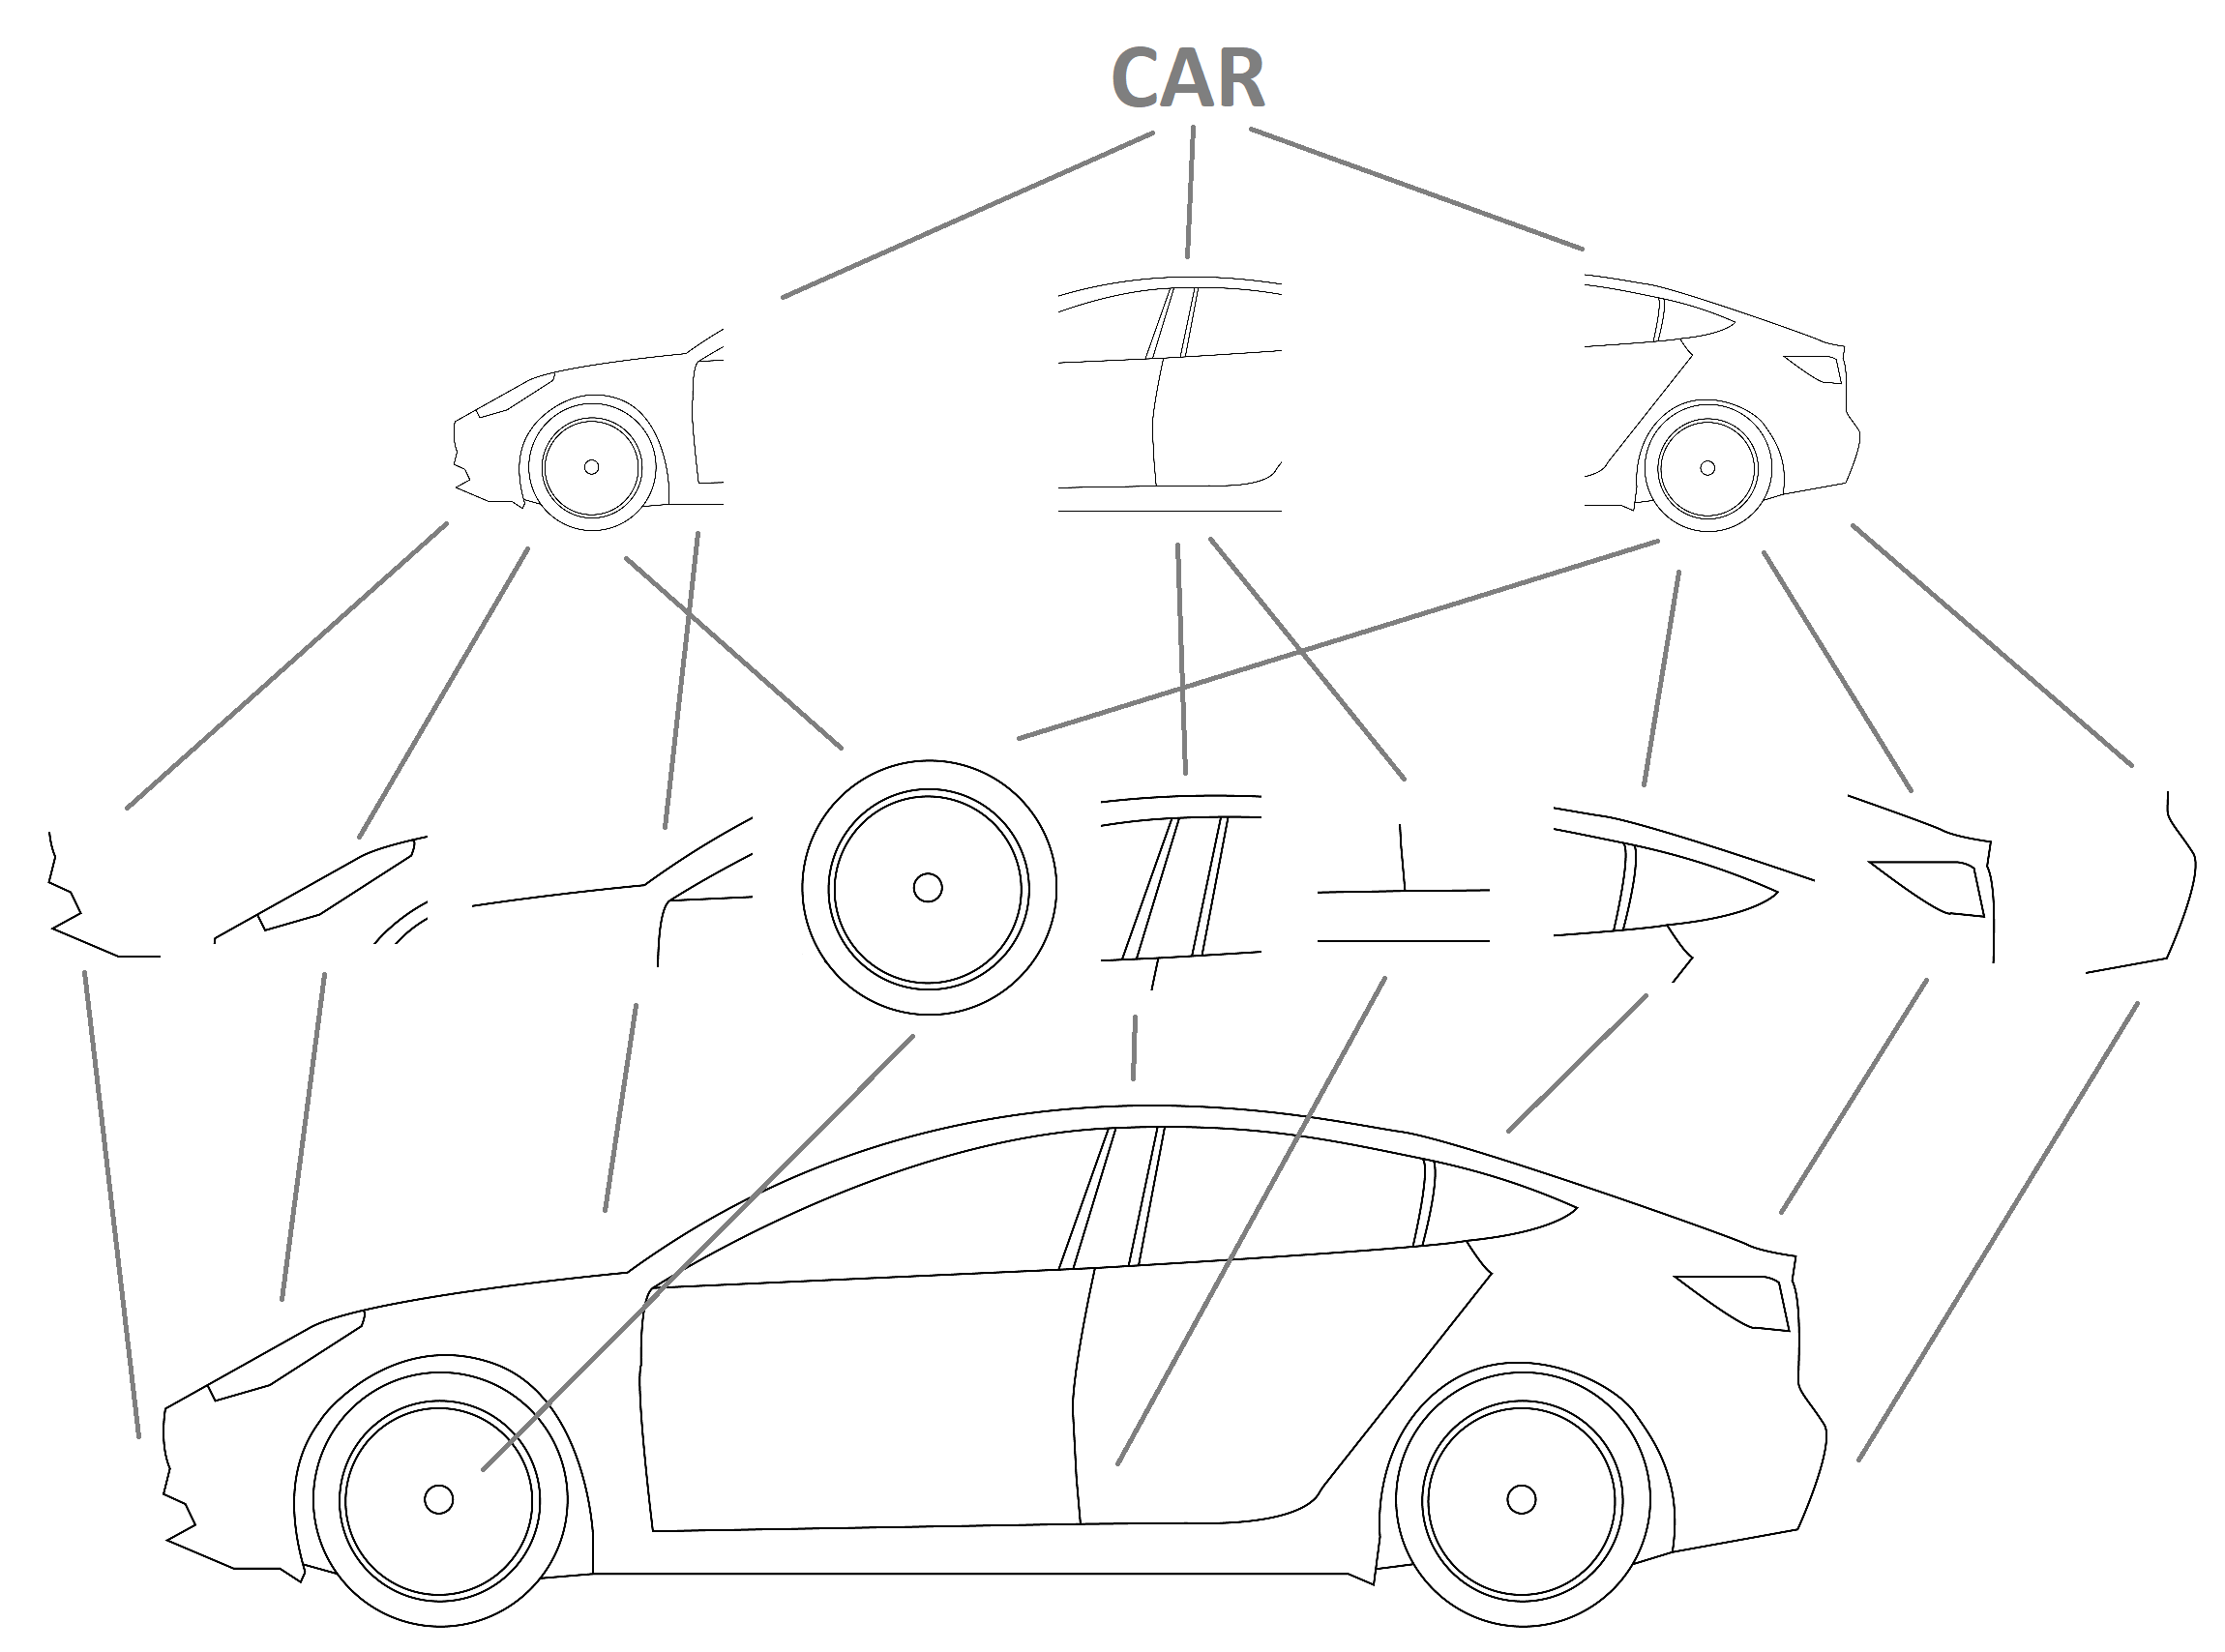

## Differences to *Multilayer perceptron*

CNNs have proven effective for any type of prediction involving image data. This is because CNNs work well with data that has a spatial relationship. MLP is now considered poor for modern advanced computer vision tasks. 
The main differences are:
    - CNN weights are smaller and shared -> more effective to train
    - Layers are less connected in CNNs rather than fully connected in MLPs -> MLPs are inefficient due to redundancy
    - CNN filters are looking for a pattern anywhere in the image

### Data set
For this example we are going to use the 
[**GTSRB**](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html) (Filename: **GTSRB_Final_Training_Images.zip**)
 data set. This is a dataset with images of german traffic signs in 42 different categories.
 Due to restrictions in Binder, we are using only three different signs to keep the computing low.

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import glob 
import cv2
import os
 
from sklearn.model_selection import train_test_split
from skimage.color import rgb2grey

In [ ]:
NUM_CLASSES = 3
np.random.seed(3)

### Preprocessing
First we need to define the directory of the images, and preprocess them to fit the requirements of our model.

In [ ]:
data_path = "src/GTSRB/Final_Training/Images" #path to the training directory
 
images = []
image_labels = []
 
# path to each image
for i in range(NUM_CLASSES):
    image_path = data_path + "/" + format(i, "05d") + "/"
    for img in glob.glob(image_path + "*.ppm"): #glob.glob finds matching files (all with .ppm file ending)
        image = cv2.imread(img) #loading the image
        image = rgb2grey(image) #converting the rgb img to a greyscale img => less computing power, only 2-dimensions
        image = cv2.resize(image, (64, 64)) #resizing to equal dimensions
        images.append(image)
        
        # creating label for the images and transfering them into a matrix
        labels = np.zeros((NUM_CLASSES, ), dtype=np.float32)
        labels[i] = 1.0
        image_labels.append(labels) # adding the labels to image_labels
 
images = np.stack([img[:, :] #stacking all img to images => 3-dimensional array
                   for img in images], # for all images
                  axis=0).astype(np.float32) # setting the datatype

image_labels = np.matrix(image_labels).astype(np.float32) # creating a image_labels matrix with labels



Let's look at the images and their shape.

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(221), plt.imshow(images[4489, :, :].reshape(64, 64), cmap="gray")
plt.subplot(222), plt.imshow(images[2359, :, :].reshape(64, 64), cmap="gray")
plt.subplot(223), plt.imshow(images[140, :, :].reshape(64, 64), cmap="gray")
plt.subplot(224), plt.imshow(images[1525, :, :].reshape(64, 64), cmap="gray")
print(image_labels[4489, :])

print(images.shape)
print(len(images))

Now we need to split our data to train and test datasets

In [ ]:
(train_X, test_X, train_y, test_y) = train_test_split(images, image_labels, 
                                                      test_size=0.2, 
                                                      random_state=3)
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

### Creating the Model
We are going to use three ```Conv2D()``` layers with a kernel size of (5, 5) and a doubling number (32>64>128) of output filters in the convolution.
We are doubling the output filter because after each Pooling layer the map volume is decreasing by a factor of 4. So doubling makes our filter makes the map volume smaller by a factor of 2.

In [ ]:
model = tf.keras.models.Sequential()
input_shape = (64, 64) # Bilder mit der Auflösung von 32x32 Pixel und Graustufe

model.add(tf.keras.layers.Conv1D(64, (5), padding='same', activation='relu', input_shape=input_shape, data_format="channels_last"))
model.add(tf.keras.layers.BatchNormalization(axis=-1))  #causes the result of one example to depend on the contents of all other examples    
model.add(tf.keras.layers.MaxPooling1D(pool_size=(2))) #by pooling, redundant information is discarded. 
model.add(tf.keras.layers.Dropout(0.2)) #prevents overfitting by removing random neurones
        
model.add(tf.keras.layers.Conv1D(128, (5), padding='same', activation='relu', data_format="channels_last"))
model.add(tf.keras.layers.BatchNormalization(axis=-1))

model.add(tf.keras.layers.Flatten())  # we need to flatten the tensor shape for the Dense layer (matrix to vector)
model.add(tf.keras.layers.Dense(512, activation='relu')) #512
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(3, activation='softmax'))


### Completing and learning the model

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(train_X, train_y, validation_data=(test_X, test_y),epochs=10)

### Plotting the results

In [ ]:
num_epochs = np.arange(0, 10)
plt.figure(dpi=300)
plt.plot(num_epochs, history.history['accuracy'], label='train_acc', c='green')
plt.plot(num_epochs, history.history['val_accuracy'], label='val_acc', c='yellow')
plt.title('Model')
plt.xlabel('epochs')
plt.ylabel('accuracy in %')
plt.legend()
plt.savefig('diagramm.png')

### Saving the model
Now we can save our model in the HDF5 (```.h5```) file format. 
The saved model basically consists of the saved model weights and the architecture of the model and the state of the optimizer to let you resume the training.

In [ ]:
#model.save("model_conv1d.h5")